# "Binary Classification with a Bank Churn Dataset" Competition

Submission by: Atul Parida

### Overview
This notebook contains the code and analysis for the "Binary Classification with a Bank Churn Dataset" competition on Kaggle. In this competition, the goal is to predict whether a customer continues with their account or closes it (e.g., churns) using the dataset provided. We will explore the dataset, preprocess the text data, build and evaluate models, and make predictions.

## Table of Contents
1. [Data Exploration](#data-exploration)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Building](#model-building)
4. [Model Evaluation](#model-evaluation)
5. [Results and Conclusion](#results-and-conclusion)


### Data Exploration

In [18]:
### Basic imports
import os
import sys

### Library imports for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
### Paths for all the files
cwd = os.getcwd()
train_data_path = os.path.join(cwd, 'data', 'train.csv')
test_data_path = os.path.join(cwd, 'data', 'test.csv')
sample_submission_path = os.path.join(cwd, 'data', 'sample_submission.csv')
output_path = os.path.join(cwd, 'output', 'output.csv')

In [20]:
train_data = pd.read_csv(train_data_path, encoding='utf-8')
test_data = pd.read_csv(test_data_path, encoding='utf-8')

In [21]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [22]:
# range of values
train_data.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>, <Axes: >]], dtype=object)

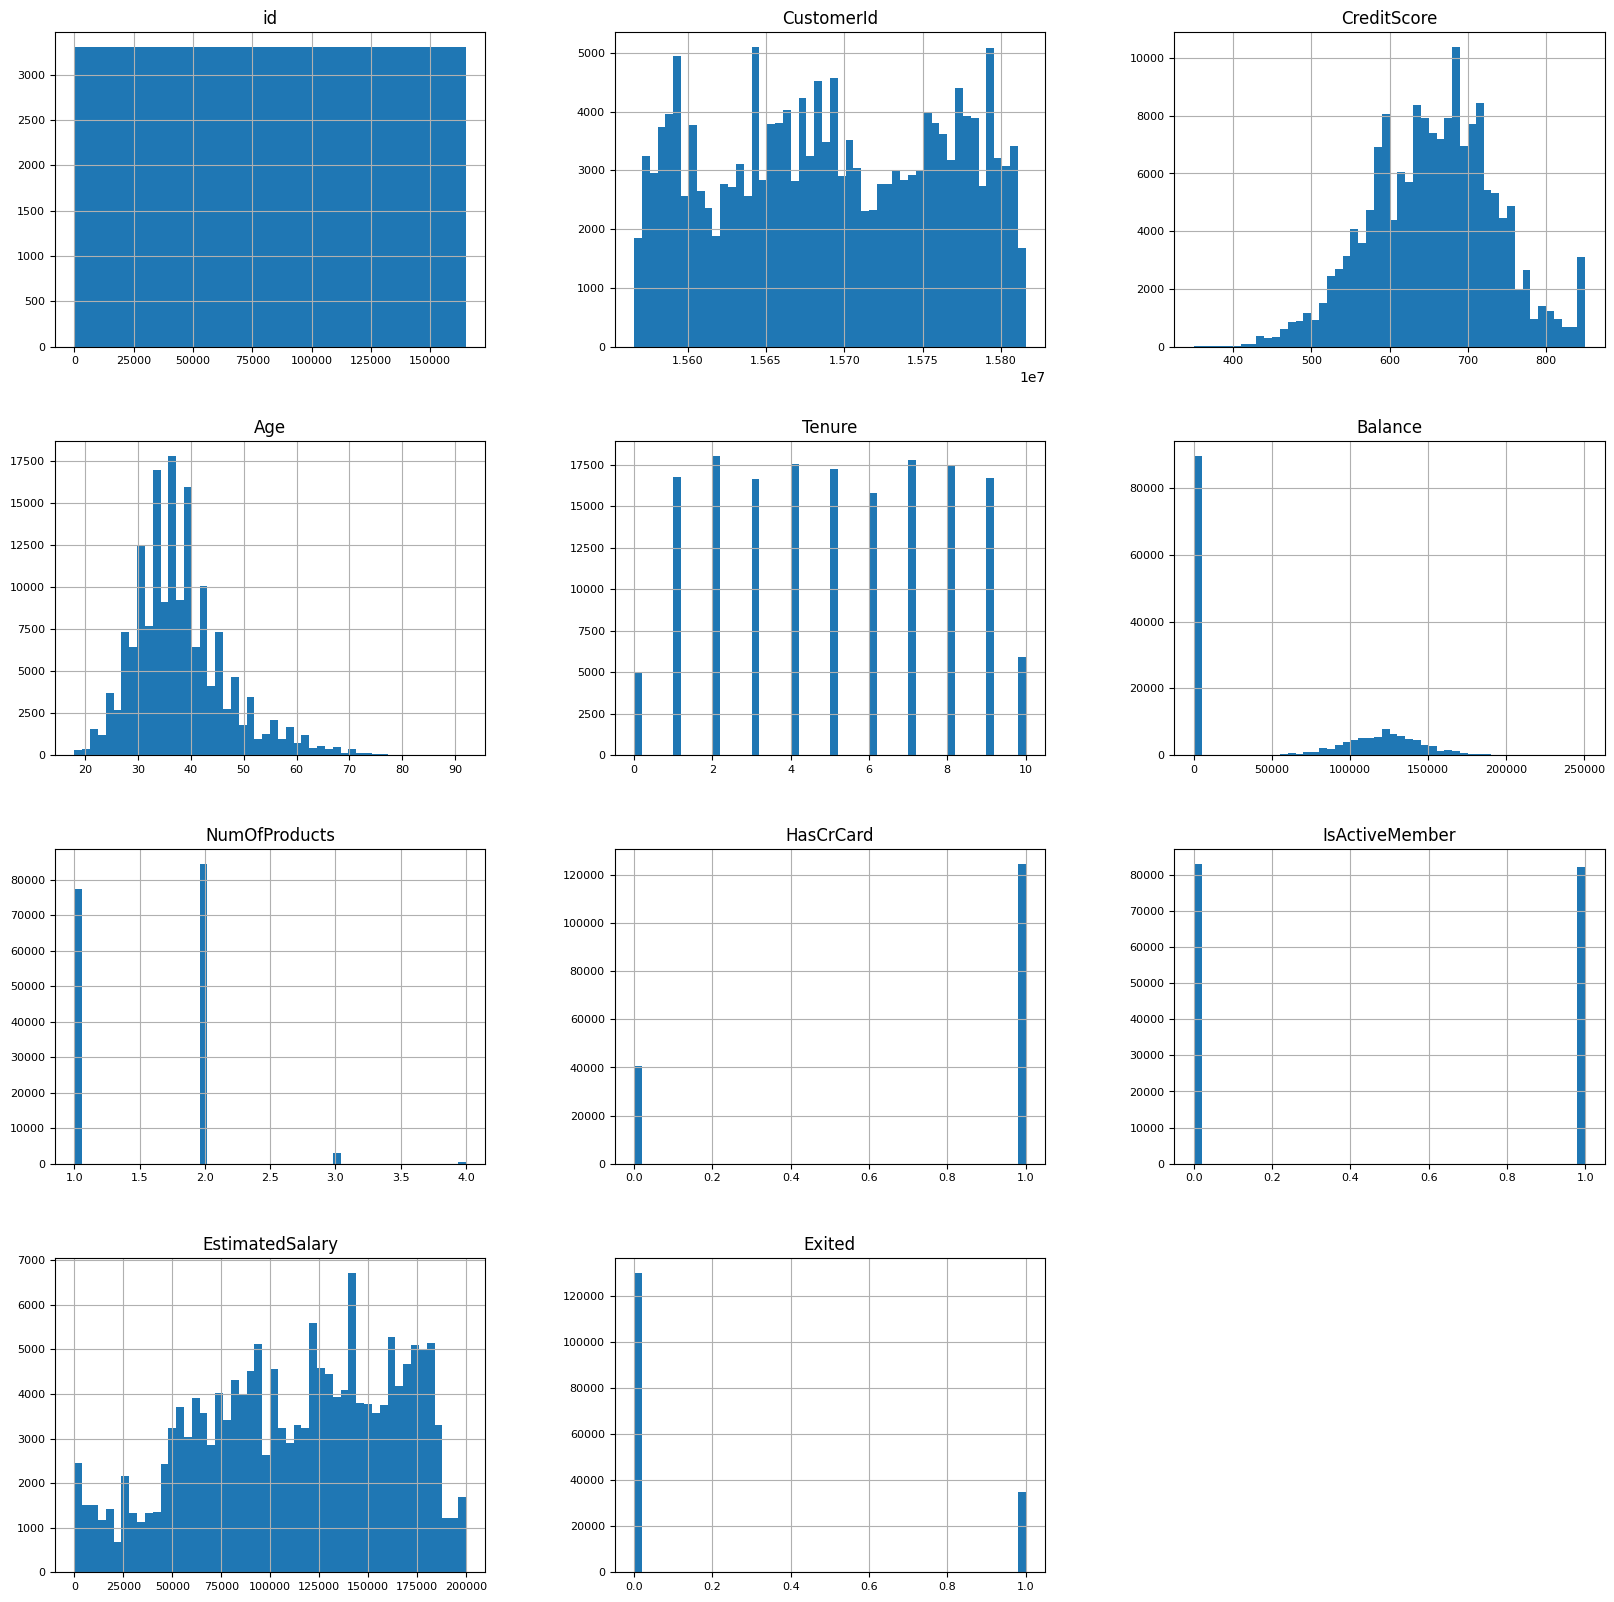

In [23]:
# graphing distributions for each column with detailed histograms
train_data.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)


It is apparent that the dataset is largely skewed towards the negative class. This will be important to keep in mind when building and evaluating models. Rebalancing the dataset may be necessary to improve model performance.

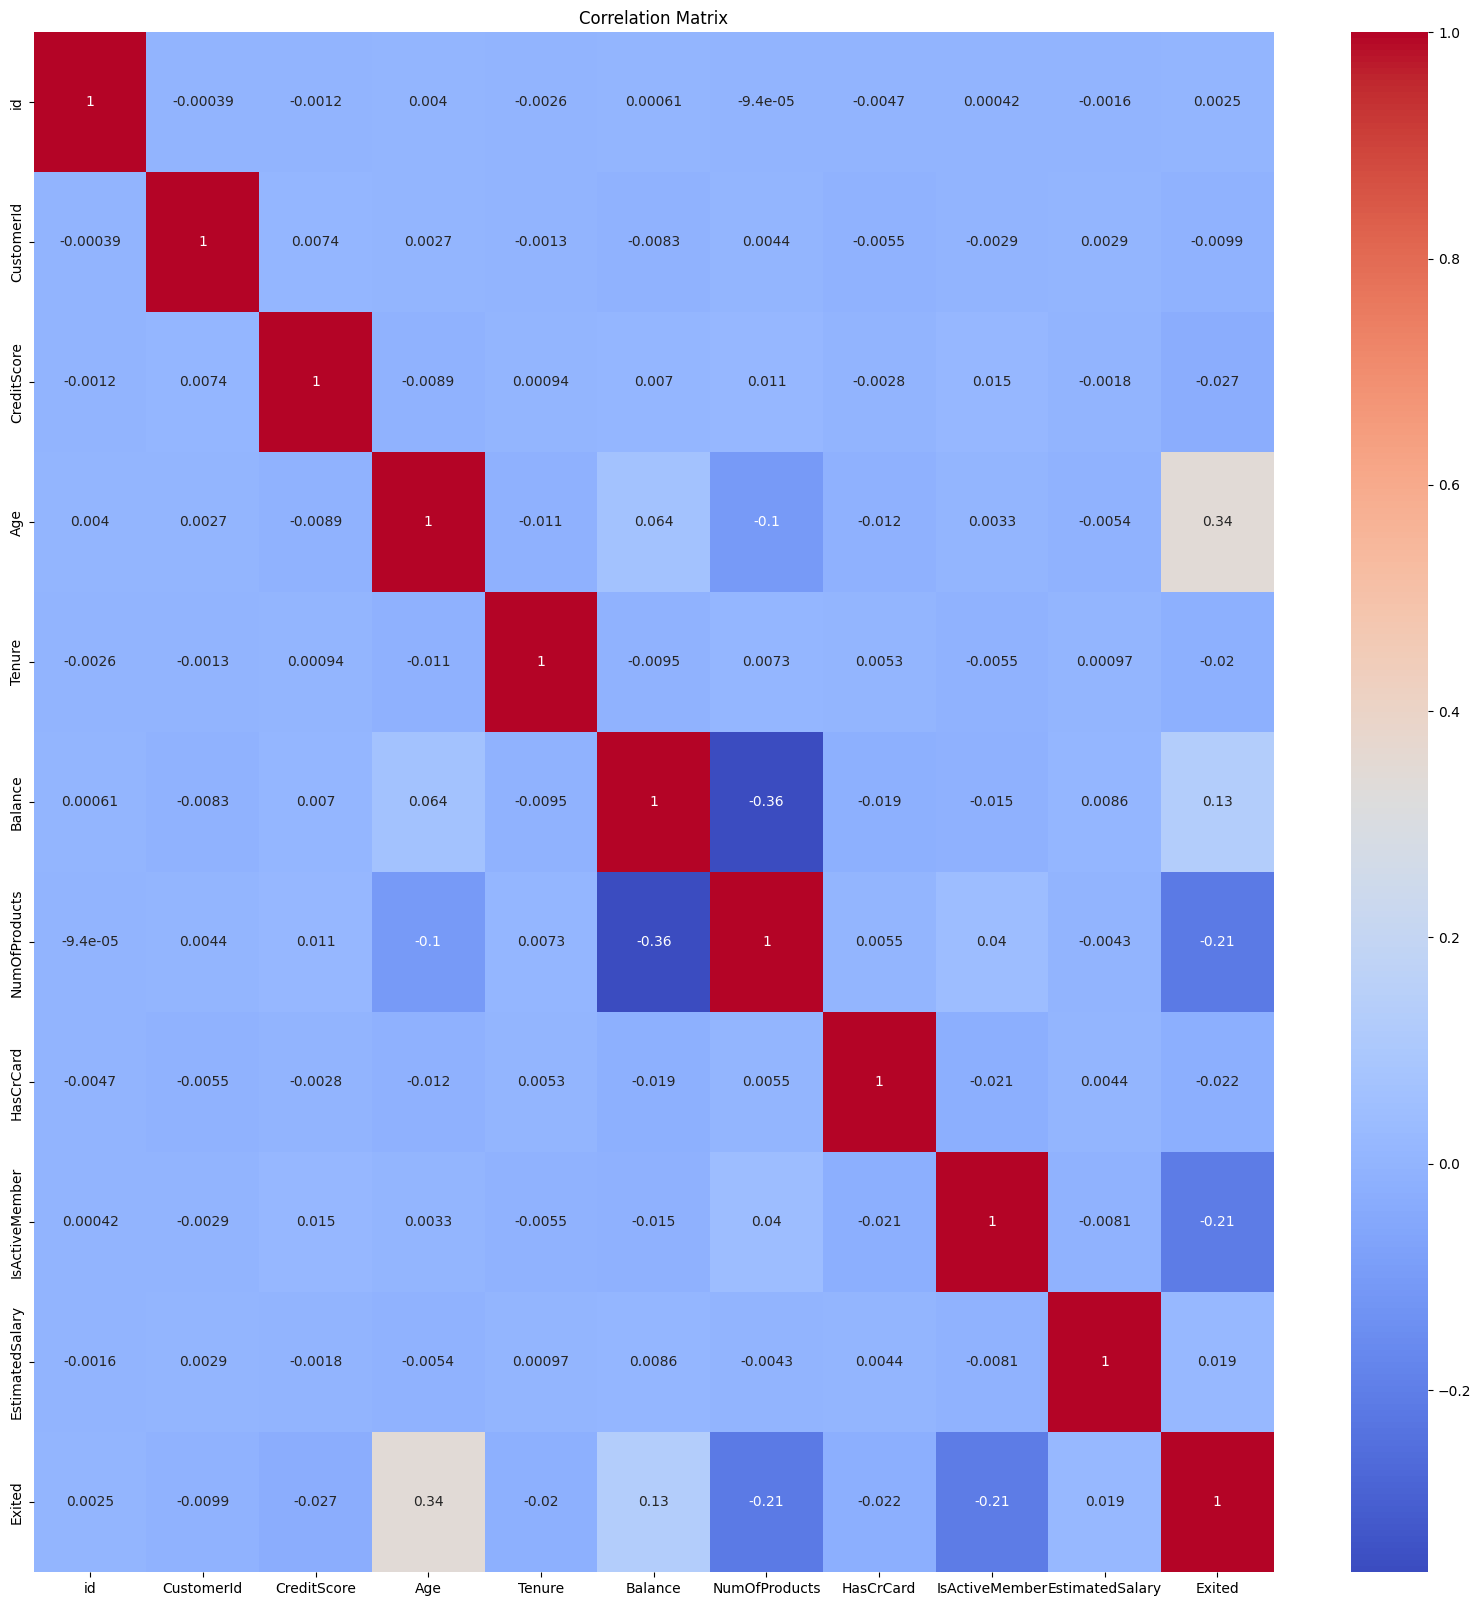

In [34]:
import seaborn as sns

# Select only the numeric columns from the dataset
numeric_columns = train_data.select_dtypes(include=np.number)

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

# increase size of heatmap
plt.rcParams['figure.figsize'] = [10, 10]

plt.show()





Preprocessing to be conducted:
- **Metafeature creation**:
    - *Name length*: length of individual's name
    - *Age to tenure ratio*: possibly older customers are more likely to churn
    - *Age to balance ratio*: older customers may have more money in their accounts
    - *Balance to tenure ratio*: customers with more money may be more likely to churn
    - *One-hot conversion for gender and geography*: gender and geographic location may be a factor in churn
- **Text preprocessing**: Names can be preprocessed to remove punctuation, numbers, and stopwords
- **Normalisation of data**: Age, balance, and tenure can be normalised to improve model performance

### Data Preprocessing

In [36]:
def add_metafeatures(df):
    # Entirely new metafeatures
    df["Name_length"] = df["Surname"].apply(len)
    df["Age vs Tenure"] = df["Age"] / df["Tenure"]
    df["Age vs Balance"] = df["Age"] / df["Balance"]
    df["Tenure vs Balance"] = df["Tenure"] / df["Balance"]

    return df

one_hot_cols = ["Gender", "Geography"]

def add_onehot(df):
    # One hot encoding for non-numeric columns
    for col in one_hot_cols:
        one_hot = pd.get_dummies(df[col], prefix=col)
        df = df.drop(col, axis=1)
        df = df.join(one_hot)

    return df

def normalise_parameters(df):
    # Normalise all parameters except one-hot encoded
    for column in df.columns:
        if column in (one_hot_cols + ["CustomerId", "Surname", "Exited"]):
            continue
        df[column] = (df[column] - df[column].mean()) / df[column].std()

    return df
    

### Model Building

### Model Evaluation

### Results and Conclusion